In [17]:
from datasets import Dataset, load_from_disk
from dataclasses import dataclass, field
import warnings
from collections import defaultdict
import os

import torch
import numpy as np

@dataclass
class SplitResults():
    # this could just be a dataset but I want type safety about the columns
    n: int
    ids: np.ndarray  # (n,)
    weak_soft_labels: np.ndarray  # (n,)
    gt_soft_labels: np.ndarray  # (n,)
    gt_hard_labels: np.ndarray  # (n,)
    logodds: np.ndarray  # (n,)

    def __post_init__(self):
        assert len(self.ids) == self.n
        assert len(self.weak_soft_labels) == self.n
        assert len(self.gt_soft_labels) == self.n
        assert len(self.gt_hard_labels) == self.n
        assert self.logodds.shape == (self.n,)

    def truncate_to(self, n: int):
        return SplitResults(
            n=n,
            ids=self.ids[:n],
            weak_soft_labels=self.weak_soft_labels[:n],
            gt_soft_labels=self.gt_soft_labels[:n],
            gt_hard_labels=self.gt_hard_labels[:n],
            logodds=self.logodds[:n],
        )


@dataclass
class GradResults():
    n_steps: int
    ids: np.ndarray  # (n,)
    steps: np.ndarray  # (n,)
    lrs: np.ndarray  # (n,)
    kernel_grads: np.ndarray  # (n, n_test)
    test_logodds: np.ndarray  # (n, n_test), logodds before the update
    proj_basis_indices: np.ndarray  # (d_down,)
    weak_soft_labels: np.ndarray  # (n,)
    gt_soft_labels: np.ndarray # (n,)
    weak_error: np.ndarray = field(init=False)  # (n,)  # weak_soft_labels - gt_soft_labels
    
    @property
    def n(self):
        return len(self.ids)

    def __post_init__(self):
        self.weak_error = self.weak_soft_labels - self.gt_soft_labels
        assert self.ids.shape == (self.n,)
        assert self.steps.shape == (self.n,)
        assert self.lrs.shape == (self.n,)
        assert self.kernel_grads.shape == (self.n, self.test_logodds.shape[1])
        assert self.test_logodds.shape == (self.n, self.kernel_grads.shape[1])
        assert self.weak_soft_labels.shape == (self.n,)
        assert self.gt_soft_labels.shape == (self.n,)
        assert self.weak_error.shape == (self.n,)

    def truncate_test_to(self, n: int):
        return GradResults(
            n_steps=self.n_steps,
            ids=self.ids,
            steps=self.steps,
            lrs=self.lrs,
            kernel_grads=self.kernel_grads[:, :n],
            test_logodds=self.test_logodds[:, :n],
            proj_basis_indices=self.proj_basis_indices,
            weak_soft_labels=self.weak_soft_labels,
            gt_soft_labels=self.gt_soft_labels,
        )

@dataclass
class RunResult():
    weak_acc: float
    strong_acc: float
    w2s_acc: float
    pgr: float
    grads: GradResults  # with n=n_train_steps
    w2s_train: SplitResults  
    w2s_vals: dict[int, SplitResults]  # step -> SplitResults
    w2s_test: SplitResults
    weak_test: SplitResults
    strong_test: SplitResults

    def __post_init__(self):
        if not (self.w2s_test.n == self.weak_test.n == self.strong_test.n):
            # sometimes these are different sizes when the runs used different batch sizes
            min_n = min(self.w2s_test.n, self.weak_test.n, self.strong_test.n)
            
            # truncate to the minimum length
            self.w2s_test = self.w2s_test.truncate_to(min_n)
            self.weak_test = self.weak_test.truncate_to(min_n)
            self.strong_test = self.strong_test.truncate_to(min_n)

        if self.w2s_test.n != self.grads.kernel_grads.shape[1]:
            # TODO: make it so we don't have to assume these are aligned
            warnings.warn(f"Test set size ({self.w2s_test.n}) does not match number of test examples in kernel_grads ({self.grads.kernel_grads.shape[1]})")
            self.grads = self.grads.truncate_test_to(self.w2s_test.n)
            
        v0 = self.w2s_vals.get(0)
        if v0 is not None:
            assert all(np.all(v.ids == v0.ids) for v in self.w2s_vals.values())
            assert all(np.all(v.weak_soft_labels == v0.weak_soft_labels) for v in self.w2s_vals.values())
            assert all(np.all(v.gt_soft_labels == v0.gt_soft_labels) for v in self.w2s_vals.values())
            assert all(np.all(v.gt_hard_labels == v0.gt_hard_labels) for v in self.w2s_vals.values())

        assert np.all(self.w2s_test.ids == self.weak_test.ids)
        assert np.all(self.w2s_test.ids == self.strong_test.ids)
        assert np.all(self.w2s_test.gt_soft_labels == self.weak_test.gt_soft_labels)
        assert np.all(self.w2s_test.gt_soft_labels == self.strong_test.gt_soft_labels)
        assert np.all(self.w2s_test.gt_hard_labels == self.weak_test.gt_hard_labels)
        assert np.all(self.w2s_test.gt_hard_labels == self.strong_test.gt_hard_labels)
        assert self.w2s_test.n == self.grads.kernel_grads.shape[1]


def load_run_result(w2s_path: str, weak_path: str, strong_path: str) -> RunResult:
        
    ### Gather validation results from throughout training ###
    val_results_paths = [p for p in os.listdir(w2s_path) if p.startswith("eval_results") and p[-1].isdigit()]
    
    w2s_val_results = dict()
    for path in val_results_paths:
        step = int(path.split("_")[-1])
        val_ds: Dataset = load_from_disk(os.path.join(w2s_path, path)).with_format("numpy")  # type: ignore

        # NOTE: for a short period, intermediate evals have a different perspective on label names
        if 'weak_soft_label' not in val_ds.column_names:
            warnings.warn("It appears these w2s val results were produced with a version of the code that called weak_soft_label \"soft_label\"")
            val_ds = val_ds.rename_columns(
                {
                    "soft_label": "weak_soft_label",
                    "hard_label": "weak_hard_label",
                }
            )
            
        w2s_val_results[step] = SplitResults(
            n=len(val_ds),
            ids=val_ds["id"],  # type: ignore
            weak_soft_labels=val_ds["weak_soft_label"][:, 1],  # type: ignore
            gt_soft_labels=val_ds["soft_label"][:, 1] if "soft_label" in val_ds.column_names else np.full(len(val_ds), np.inf),  # type: ignore
            gt_hard_labels=val_ds["hard_label"] if "hard_label" in val_ds.column_names else np.full(len(val_ds), np.inf),  # type: ignore
            logodds=val_ds["logit"][:, 1] - val_ds["logit"][:, 0],  # type: ignore
        )
    
    ### Load test results ###
    test_results = dict()
    for name, path in zip(["weak", "strong", "w2s"], [weak_path, strong_path, w2s_path]):
        test_ds: Dataset = load_from_disk(os.path.join(path, "eval_results_final")).with_format("numpy")  # type: ignore
        try:
            logodds = test_ds["logit"][:, 1] - test_ds["logit"][:, 0]  # type: ignore
        except KeyError:
            warnings.warn(f"Could not find logit columns in {path}, inferring from \"soft_pred\" instead")
            p = test_ds["soft_pred"][:, 1]  # type: ignore
            logodds = np.log(p / ((1 - p) + 1e-12) + 1e-12)
        test_results[name] = SplitResults(
            n=len(test_ds),
            ids=test_ds["id"],  # type: ignore
            weak_soft_labels=test_ds["weak_soft_label"][:, 1] if name == "w2s" else np.full(len(test_ds), np.inf),  # type: ignore
            gt_soft_labels=test_ds["soft_label"][:, 1],  # type: ignore
            gt_hard_labels=test_ds["hard_label"],  # type: ignore
            logodds=logodds,
        )

    ### Load training results ###
    # note that in this case "soft_label" means weak_soft_label, and there is a "gt_soft_label" column
    train_ds: Dataset = load_from_disk(os.path.join(w2s_path, "train_ds")).with_format("numpy")  # type: ignore
    w2s_train_ds = SplitResults(
        n=len(train_ds),
        ids=train_ds["id"],  # type: ignore
        weak_soft_labels=train_ds["soft_label"][:, 1],  # type: ignore
        gt_soft_labels=train_ds["gt_soft_label"][:, 1],  # type: ignore
        gt_hard_labels=train_ds["gt_hard_label"],  # type: ignore
        logodds=np.full(len(train_ds), np.inf),  # train_ds doesn't contain predictions
    )

    ### Load gradient results ###
    num_steps = max(int(p.split("_")[-1][:-3]) for p in os.listdir(w2s_path) if p.startswith("gradients")) + 1
    grad_dict = defaultdict(list)
    proj_basis_indices = None
    for i in range(num_steps):
        grad_batch = torch.load(os.path.join(w2s_path, f"gradients_{i}.pt"), map_location="cpu")
        this_bs = len(grad_batch["ids"])
        grad_dict["ids"].append(np.array(grad_batch["ids"]))
        grad_dict["steps"].append(np.array([grad_batch["step"]] * this_bs))
        grad_dict["lrs"].append(np.array([grad_batch["lr"]] * this_bs))
        grad_dict["kernel_grads"].append(grad_batch["expected_effects"].numpy())
        grad_dict["test_logodds"].append(grad_batch["eval_outputs"].expand(this_bs, -1).numpy())
        if proj_basis_indices is None:
            proj_basis_indices = grad_batch["proj_basis_indices"].numpy()
        assert np.all(proj_basis_indices == grad_batch["proj_basis_indices"].numpy())
    
    grad_dict = {k: np.concatenate(v) for k, v in grad_dict.items()}
    
    # join the weak_soft_labels and gt_soft_labels from the training set
    n_grads = len(grad_dict["ids"])
    n_epochs = n_grads // len(w2s_train_ds.ids)
    grad_dict["weak_soft_labels"] = w2s_train_ds.weak_soft_labels.repeat(n_epochs + 1)[:n_grads]
    grad_dict["gt_soft_labels"] = w2s_train_ds.gt_soft_labels.repeat(n_epochs + 1)[:n_grads]
    # ensure the labels are assigned to the corresponding rows
    gids = w2s_train_ds.ids.repeat(n_epochs + 1)[:n_grads]
    assert np.all(gids == grad_dict["ids"])

    grad_results = GradResults(
        n_steps=num_steps,
        proj_basis_indices=proj_basis_indices,  # type: ignore
        **grad_dict
    )

    ### Compute accuracy metrics ###
    accs = {
        name: np.mean(test_results[name].gt_hard_labels == (test_results[name].logodds > 0))
        for name in ["weak", "strong", "w2s"]
    }
    pgr = (accs["w2s"] - accs["weak"]) / (accs["strong"] - accs["weak"])

    return RunResult(
        weak_acc=accs["weak"],
        strong_acc=accs["strong"],
        w2s_acc=accs["w2s"],
        pgr=pgr,
        grads=grad_results,
        w2s_train=w2s_train_ds,
        w2s_vals=w2s_val_results,
        w2s_test=test_results["w2s"],
        weak_test=test_results["weak"],
        strong_test=test_results["strong"],
    )


/mnt/ssd-1/adam/weak-to-strong/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TopoFilter etc

In [21]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.sparse.csgraph import connected_components
from sklearn.neighbors import NearestNeighbors, kneighbors_graph


def subgraph(knn, y):
    return knn[y][:, y]

def count_like_neighbors(knn, y):
    G = subgraph(knn, y)
    return np.bincount(G.nonzero()[0])

def largest_component(knn):
    components = connected_components(knn)[1]
    top_component_idx = np.bincount(components).argmax()
    return components==top_component_idx

def union_bools(a, b):
    # composition of (bool vector) subsets
    # b subset of a
    # a subset of S
    # returns b as subset of S
    a_ = a.copy()
    a_[a_] = b 
    return a_

def topoCC(x, y, k):
    # returns indices of points in the largest connected component of their class
    # "G"
    knn = kneighbors_graph(x, k, mode='connectivity', include_self=True)
    G1 = subgraph(knn, y)
    G0 = subgraph(knn, ~y)
    
    # bools for top components "Qi" = "Si" within class subgraphs Gi
    topG1 = largest_component(G1)
    topG0 = largest_component(G0)
    
    # bools for Qi within G
    base1 = union_bools(y, topG1)
    base0 = union_bools(~y, topG0)
    # bool for "C" = "S" within G
    base = base1 + base0

    return base

def topofilter(x, y, k, m):
    # returns high scores for predicted correct labels, low scores for flipped labels
    n = x.shape[0]

    base = topoCC(x, y, k)
    # points and labels for S
    xS = x[base]
    yS = y[base]

    # # knn for S
    # knn = NearestNeighbors(n_neighbors=m).fit(xS).kneighbors_graph(xS)
    # # like-neighbor counts within Qi
    # neighborsfilter1 = count_like_neighbors(knn, yS) / m
    # neighborsfilter0 = count_like_neighbors(knn, ~yS) / m
    
    # scores = np.zeros(n)
    # # like-neighbor counts within G
    # scores[base1] = neighborsfilter1
    # scores[base0] = neighborsfilter0

    scoresS = knn_score(xS, yS, m)
    scores = np.zeros(n)
    scores[base] = scoresS

    return scores

def knn_score(x, y, m):
    n = x.shape[0]
    knn = kneighbors_graph(x, m, mode='connectivity', include_self=True)
    neighborsfilter1 = count_like_neighbors(knn, y) / m
    neighborsfilter0 = count_like_neighbors(knn, ~y) / m

    scores = np.zeros(n)
    scores[y] = neighborsfilter1
    scores[~y] = neighborsfilter0

    return scores


def clean_data(x, y, k, m, zeta):
    scores = topofilter(x, y, k, m)
    clean = scores >= zeta
    return x[clean], y[clean], clean, scores

In [22]:
def run_topo(x, y, correct, ks, ms, knnscore=False):
        
    ks_success = []
    ms_success = []
    aucs = []
    fprs = []
    tprs = []
    counts = []

    for k, m in zip(ks, ms):
        try:
            if knnscore:
                scores = knn_score(x, y, m)
            else:
                scores = topofilter(x, y, k, m)
        except ValueError:
            continue
        aucs.append(roc_auc_score(correct, scores))
        # sort correct by scores
        correct_sort = correct[np.argsort(-scores)]
        scores_sort = scores[np.argsort(-scores)]
        # find points where scores change
        change = np.where(np.diff(scores_sort))[0] + 1
        # compute TP, FP, FN, TN at each change point

        TP = np.cumsum(correct_sort)[change]
        FP = np.cumsum(~correct_sort)[change]
        FN = np.sum(correct_sort) - TP
        TN = np.sum(~correct_sort) - FP
        
        counts.append((TP, FP, FN, TN))
        # fpr, tpr, _ = roc_curve(correct, scores)

        ks_success.append(k)
        ms_success.append(m)

    return ks_success, ms_success, aucs, counts

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [16]:
def plot_frac_prec(ks_success, aucs, counts, title, dots=False, ylim=(0.7, 1)):
    
    max_k = max(ks_success)

    fig, ax = plt.subplots()

    for k, auc, count in zip(ks_success, aucs, counts):
        TP, FP, FN, TN = count
        prec = TP / (TP + FP)
        kept = (TP + FP) / len(y)
        plt.plot(kept, prec, color=plt.cm.viridis(k / max_k))
        if dots:
            plt.plot(kept[:1], prec[:1], "o", color="red")

    plt.title(title)
    plt.xlabel("frac kept")
    plt.ylabel("precision")
    # colorbar for k, ranging from 1 to max_k
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(0, max_k)), label="k", ax=ax)
    # truncate y axis
    plt.ylim(*ylim)
    plt.show()

def plot_roc(ks_success, aucs, counts, title):
    max_k = max(ks_success)

    fig, ax = plt.subplots()

    for k, auc, count in zip(ks_success, aucs, counts):
        TP, FP, FN, TN = count
        FPR = FP / (FP + TN)
        TPR = TP / (TP + FN)
        plt.plot(FPR, TPR, color=plt.cm.viridis(k / max_k))

    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    # colorbar for k, ranging from 1 to max_k
    plt.colorbar(plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(0, max_k)), label="k", ax=ax)

    plt.ylim(0, 1)
    plt.show()

## Noisier JVP estimates

In [7]:
results_dir = "/mnt/ssd-1/alexm/weak-to-strong/results"

weak_path = f"{results_dir}/function-grads/amazon_polarity/bs=32-dl=1-dn=amaz_pola-e=1-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=pythia-14m-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=0-twd=0"
strong_path = f"{results_dir}/function-grads/amazon_polarity/bs=32-dl=1-dn=amaz_pola-e=1-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Qwen1.5-0.5B-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=0-twd=0"
w2s_path = f"{results_dir}/function-grads/amazon_polarity/bs=64-dl=1-dn=amaz_pola-e=1-ee=25-gib=1-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Qwen1.5-0.5B-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=1-twd=0-wms=pythia-14m"
r = load_run_result(w2s_path, weak_path, strong_path)

/tmp/ipykernel_387677/2628982803.py:135: UserWarning: It appears these w2s val results were produced with a version of the code that called weak_soft_label "soft_label"
  warnings.warn("It appears these w2s val results were produced with a version of the code that called weak_soft_label \"soft_label\"")


In [8]:
r.weak_acc, r.strong_acc, r.w2s_acc, r.pgr

(0.7979166666666667,
 0.9666666666666667,
 0.8854166666666666,
 0.5185185185185182)

In [10]:
r.grads.kernel_grads.shape

(9472, 480)

In [13]:
r.w2s_test.gt_hard_labels.shape

(480,)

In [14]:
r.grads.gt_soft_labels.shape

(9472,)

In [20]:
x = r.grads.kernel_grads
y = r.grads.weak_soft_labels > 0.5

correct = (r.grads.gt_soft_labels == y)

ks = [*range(1, 10), *range(10, 100, 10), *range(100, 1000, 100)]

result_kk = run_topo(x, y, correct, ks, ks)

In [47]:
result_k_200 = run_topo(x, y, correct, ks, [200 for k in ks])

In [46]:
result_200_k = run_topo(x, y, correct, [200 for k in ks], ks)

In [77]:
result_30_k = run_topo(x, y, correct, [30 for k in ks], ks)

In [78]:
result_10_k = run_topo(x, y, correct, [10 for k in ks], ks)

KeyboardInterrupt: 

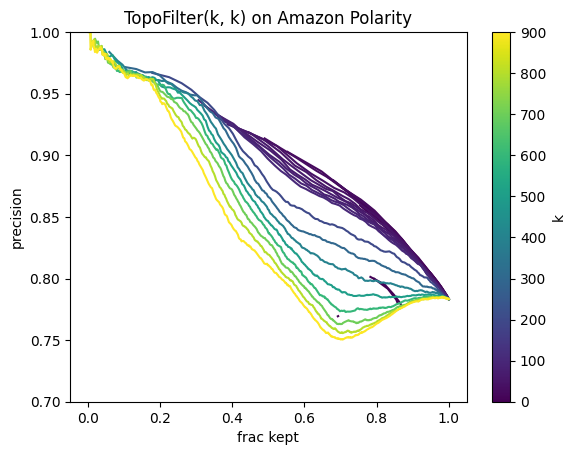

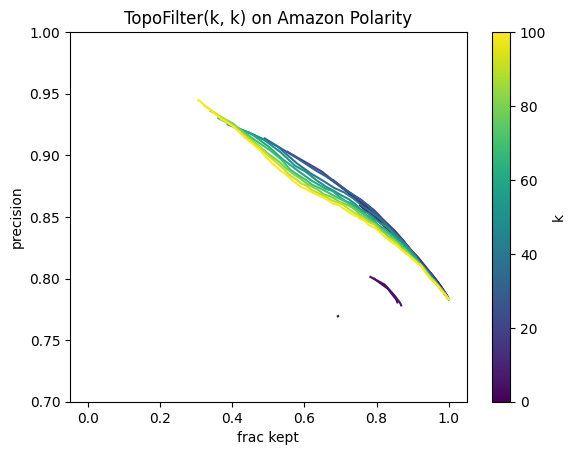

In [33]:
ks_success, _, aucs, counts = result_kk

plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, k) on Amazon Polarity")

ks_success = [k for k in ks_success if k <= 100]

plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, k) on Amazon Polarity")

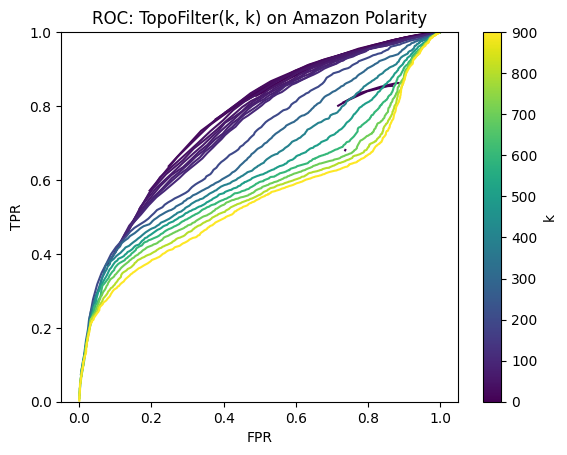

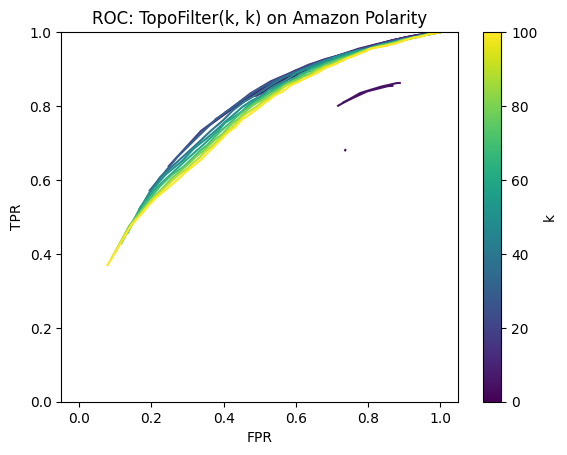

In [34]:
ks_success, _, aucs, counts = result_kk

plot_roc(ks_success, aucs, counts, "ROC: TopoFilter(k, k) on Amazon Polarity")

ks_success = [k for k in ks_success if k <= 100]

plot_roc(ks_success, aucs, counts, "ROC: TopoFilter(k, k) on Amazon Polarity")

In [94]:
aucs_100 = aucs

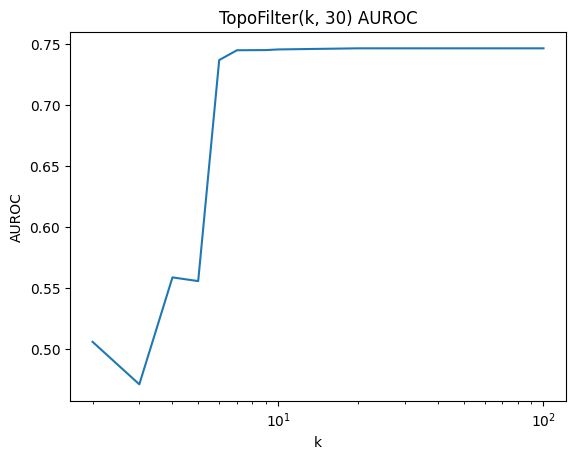

In [135]:
plt.semilogx(ks_success, aucs)
plt.xlabel("k")
plt.ylabel("AUROC")
plt.title("TopoFilter(k, 30) AUROC")
plt.show()

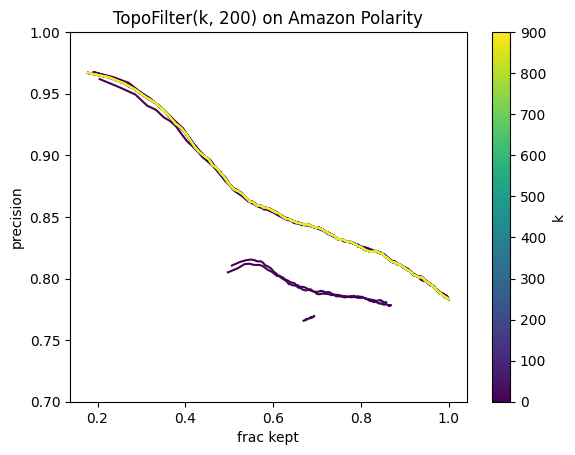

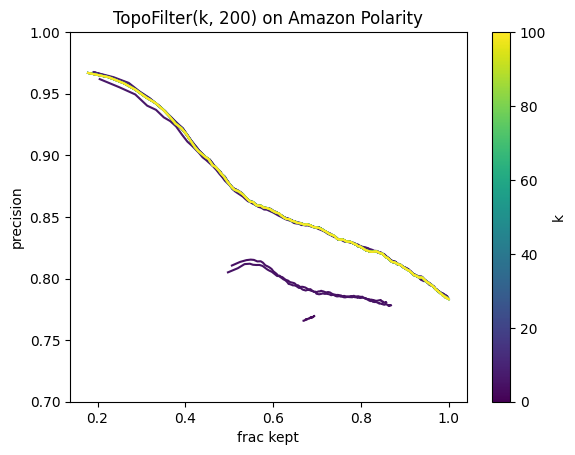

In [49]:
ks_success, ms_success, aucs, counts = result_k_200

plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, 200) on Amazon Polarity")

ks_success = [k for k in ks_success if k <= 100]
plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, 200) on Amazon Polarity")

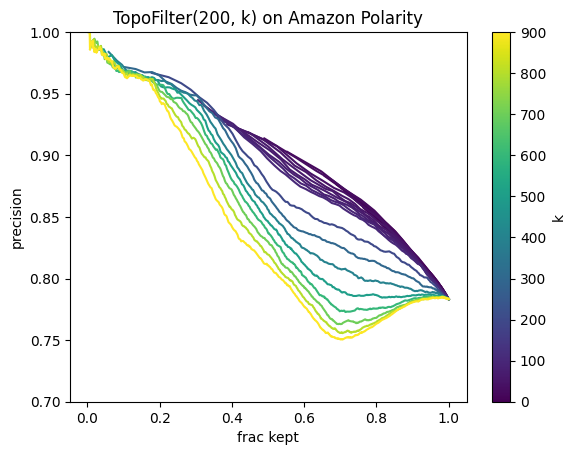

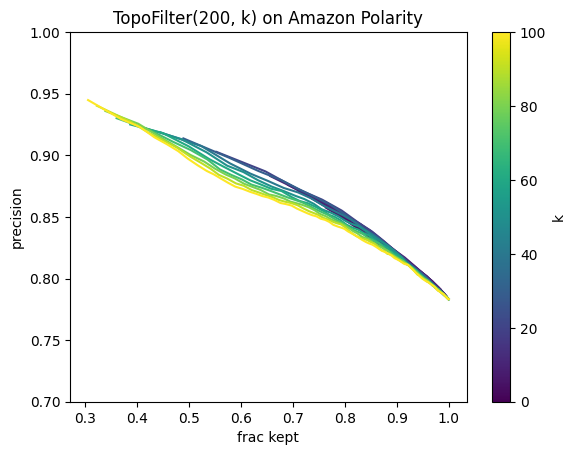

In [48]:
ks_success, ms_success, aucs, counts = result_200_k

plot_frac_prec(ms_success, aucs, counts, "TopoFilter(200, k) on Amazon Polarity")

ms_success = [k for k in ms_success if k <= 100]

plot_frac_prec(ms_success, aucs, counts, "TopoFilter(200, k) on Amazon Polarity")

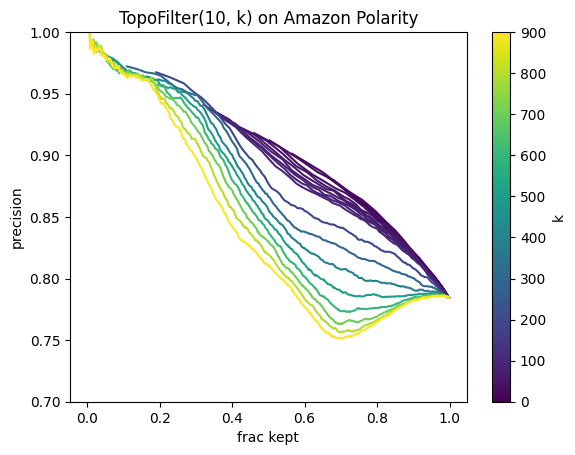

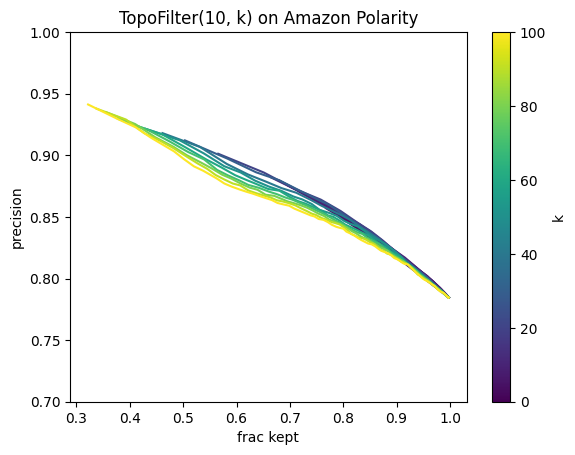

In [55]:
ks_success, ms_success, aucs, counts = result_10_k

plot_frac_prec(ms_success, aucs, counts, "TopoFilter(10, k) on Amazon Polarity")

ms_success = [k for k in ms_success if k <= 100]
plot_frac_prec(ms_success, aucs, counts, "TopoFilter(10, k) on Amazon Polarity")

### one-off runs

In [143]:
x = r.grads.kernel_grads
y = r.grads.weak_soft_labels > 0.5

x_clean, y_clean, clean, scores = clean_data(x, y, 30, 30, 1.)

correct = r.grads.gt_soft_labels == y

print(clean.sum() / len(clean))
print(correct.sum() / len(correct))
print(correct[~clean].sum() / (~clean).sum())
print(correct[clean].sum() / clean.sum())

0.48944256756756754
0.7832559121621622
0.6579818031430935
0.9139344262295082


## Less noisy JVP

In [23]:
results_dir = "/mnt/ssd-1/alexm/weak-to-strong/results"

weak_path = "../results/function-grads/amazon_polarity/bs=32-dd=1000000-dl=1-dn=amaz_pola-e=1-ee=50-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-ms=pythia-14m-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=0-twd=0"
strong_path = "../results/function-grads/amazon_polarity/bs=32-dd=1000000-dl=1-dn=amaz_pola-e=1-ee=50-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-ms=Qwen1.5-0.5B-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=0-twd=0"
w2s_path = "../results/function-grads/amazon_polarity/bs=64-dd=1000000-dl=1-dn=amaz_pola-e=1-ee=25-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-ms=Qwen1.5-0.5B-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=1-twd=0-wms=pythia-14m"

weak_path = weak_path.replace("../results", results_dir)
strong_path = strong_path.replace("../results", results_dir)
w2s_path = w2s_path.replace("../results", results_dir)

r = load_run_result(w2s_path, weak_path, strong_path)

In [24]:
x = r.grads.kernel_grads
y = r.grads.weak_soft_labels > 0.5

correct = (r.grads.gt_soft_labels == y)

ks = [*range(1, 10), *range(10, 100, 10), *range(100, 1000, 100)]

result_kk = run_topo(x, y, correct, ks, ks)

In [11]:
x.shape, y.shape

((9472, 500), (9472,))

In [68]:
result_k_200 = run_topo(x, y, correct, ks, [200 for k in ks])

In [87]:
result_200_k = run_topo(x, y, correct, [200 for k in ks], ks)

In [12]:
result_30_k = run_topo(x, y, correct, [30 for k in ks], ks)

In [16]:
result_knn_k = run_topo(x, y, correct, [-1 for k in ks], ks, knnscore=True)

In [82]:
result_k_30 = run_topo(x, y, correct, ks, [30 for k in ks])

In [80]:
result_10_k = run_topo(x, y, correct, [10 for k in ks], ks)

### plots

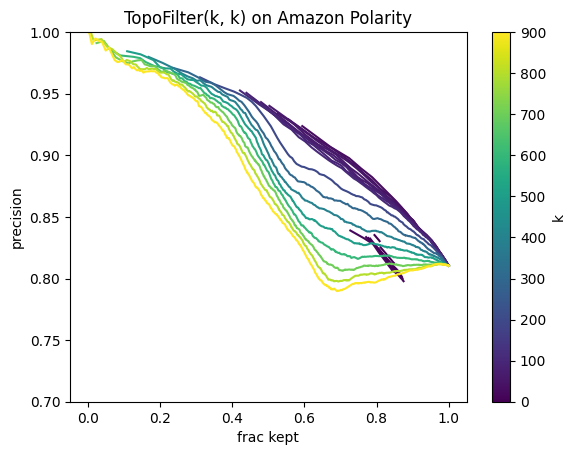

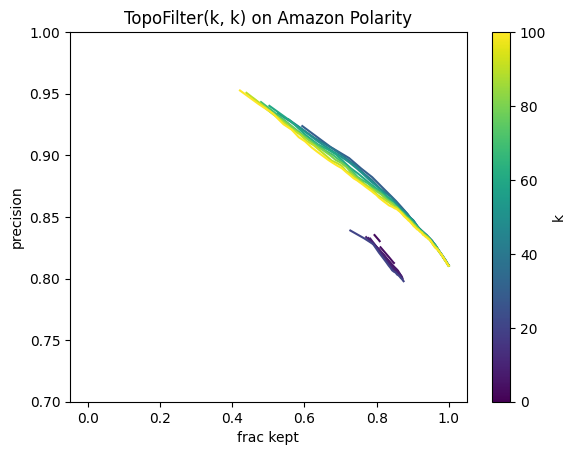

In [25]:
ks_success, _, aucs, counts = result_kk

plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, k) on Amazon Polarity")

ks_success = [k for k in ks_success if k <= 100]

plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, k) on Amazon Polarity")

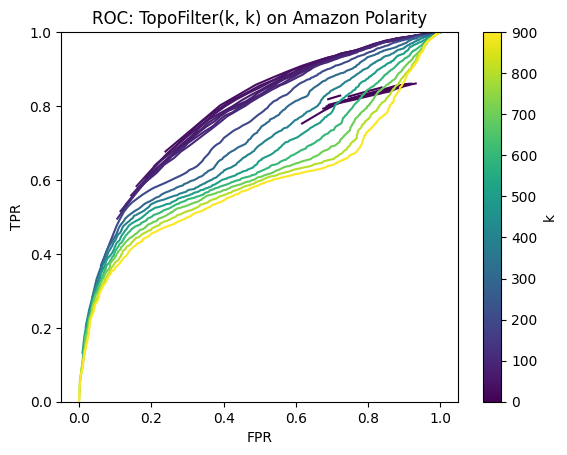

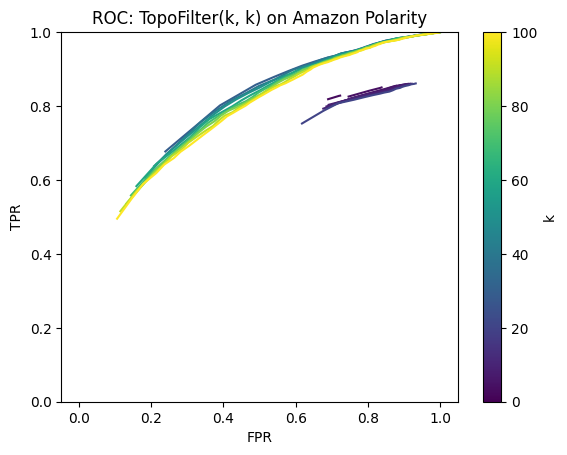

In [67]:
ks_success, _, aucs, counts = result_kk

plot_roc(ks_success, aucs, counts, "ROC: TopoFilter(k, k) on Amazon Polarity")

ks_success = [k for k in ks_success if k <= 100]

plot_roc(ks_success, aucs, counts, "ROC: TopoFilter(k, k) on Amazon Polarity")

In [ ]:
aucs_100 = aucs

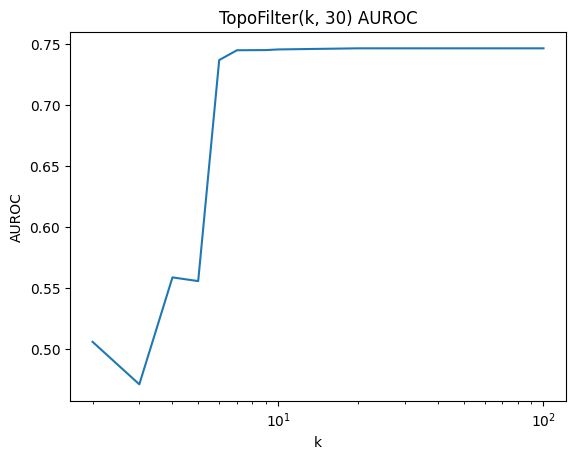

In [ ]:
plt.semilogx(ks_success, aucs)
plt.xlabel("k")
plt.ylabel("AUROC")
plt.title("TopoFilter(k, 30) AUROC")
plt.show()

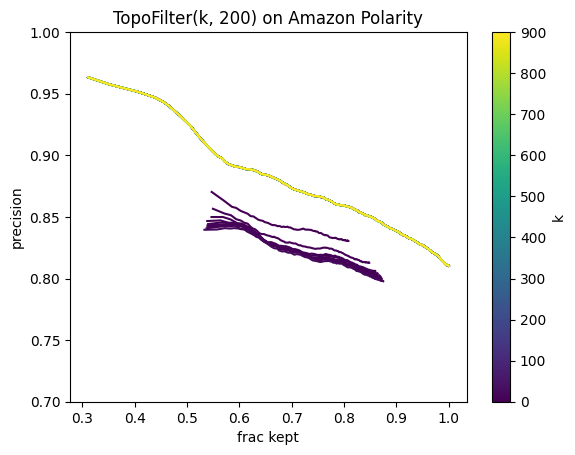

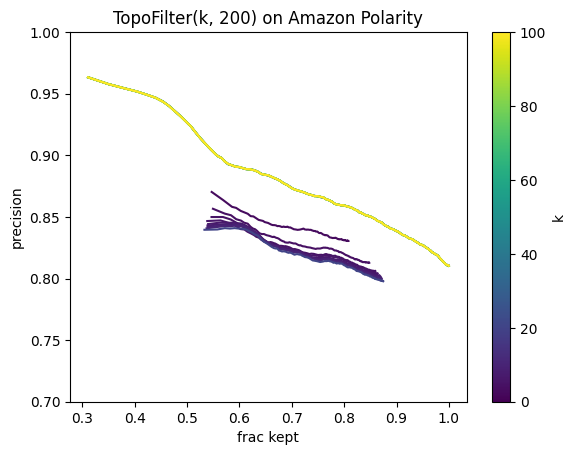

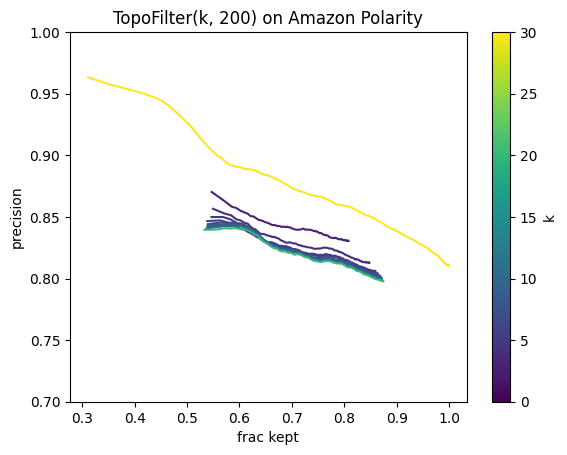

In [76]:
ks_success, ms_success, aucs, counts = result_k_200

plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, 200) on Amazon Polarity")

ks_success = [k for k in ks_success if k <= 100]
plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, 200) on Amazon Polarity")
ks_success = [k for k in ks_success if k <= 30]
plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, 200) on Amazon Polarity")

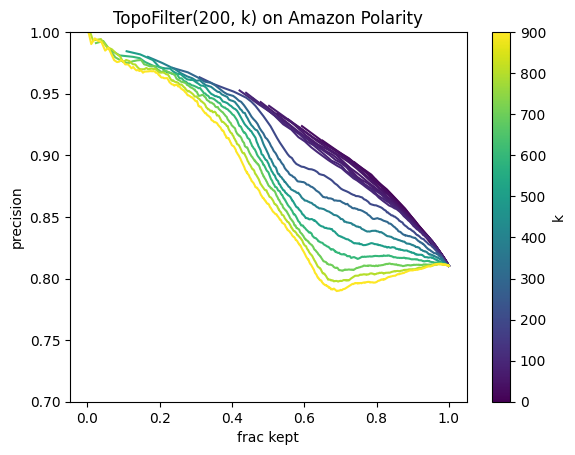

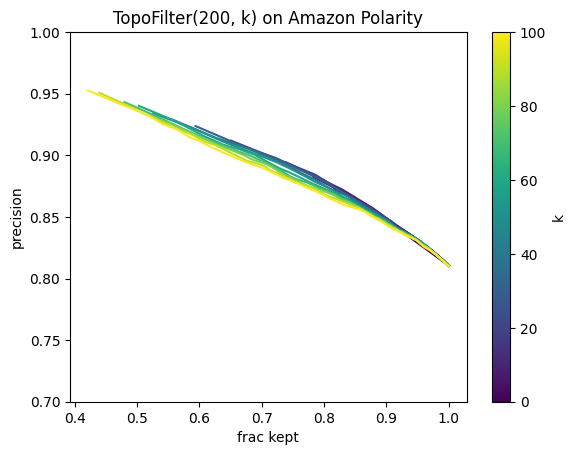

In [88]:
ks_success, ms_success, aucs, counts = result_200_k

plot_frac_prec(ms_success, aucs, counts, "TopoFilter(200, k) on Amazon Polarity")

ms_success = [k for k in ms_success if k <= 100]

plot_frac_prec(ms_success, aucs, counts, "TopoFilter(200, k) on Amazon Polarity")

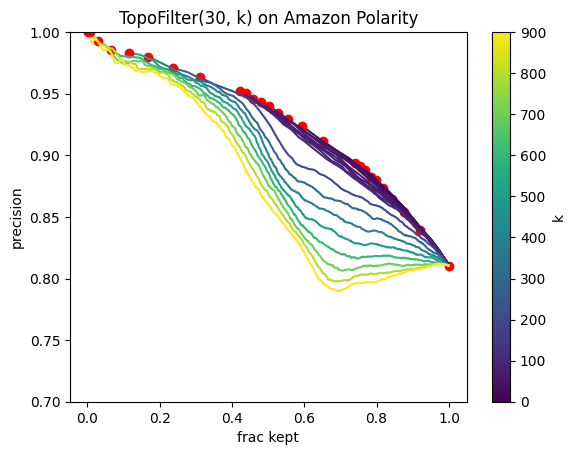

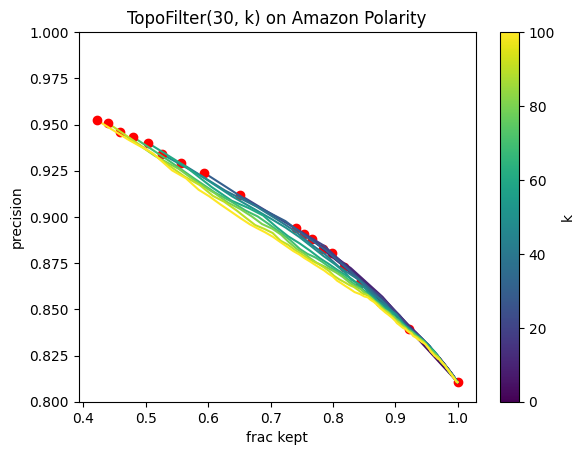

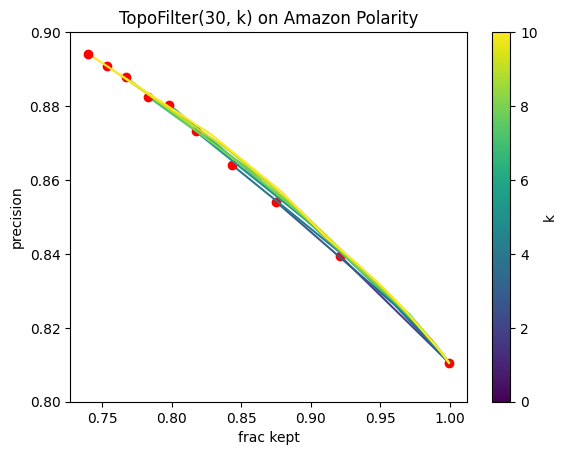

In [13]:
ks_success, ms_success, aucs, counts = result_30_k

plot_frac_prec(ms_success, aucs, counts, "TopoFilter(30, k) on Amazon Polarity", dots=True)

ms_success = [k for k in ms_success if k <= 100]
plot_frac_prec(ms_success, aucs, counts, "TopoFilter(30, k) on Amazon Polarity", dots=True, ylim=(0.8, 1))

ms_success = [k for k in ms_success if k <= 10]
plot_frac_prec(ms_success, aucs, counts, "TopoFilter(30, k) on Amazon Polarity", dots=True, ylim=(0.8, 0.9))

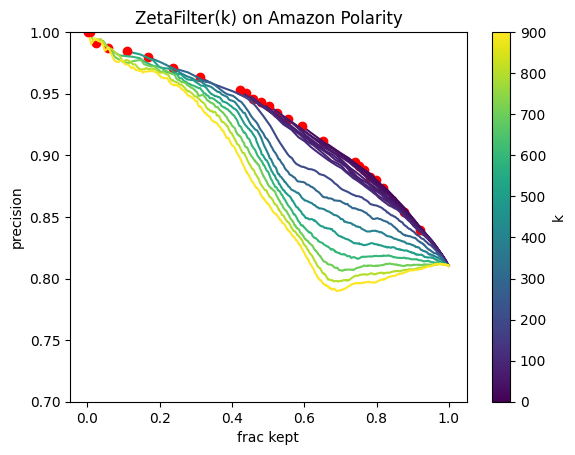

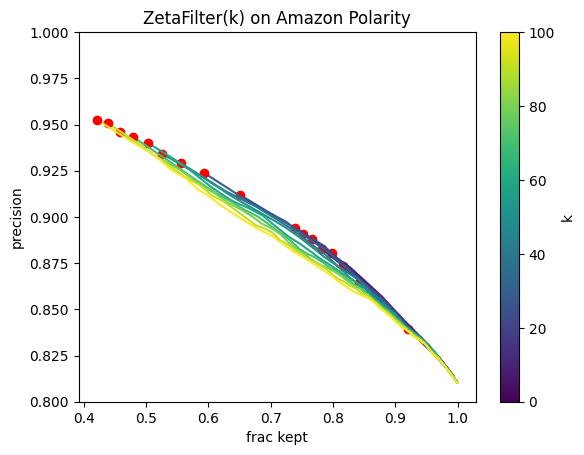

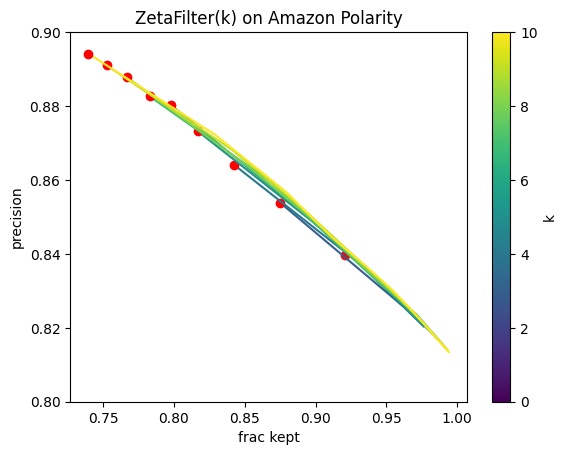

In [17]:
ks_success, ms_success, aucs, counts = result_knn_k

plot_frac_prec(ms_success, aucs, counts, "ZetaFilter(k) on Amazon Polarity", dots=True)

ms_success = [k for k in ms_success if k <= 100]
plot_frac_prec(ms_success, aucs, counts, "ZetaFilter(k) on Amazon Polarity", dots=True, ylim=(0.8, 1))

ms_success = [k for k in ms_success if k <= 10]
plot_frac_prec(ms_success, aucs, counts, "ZetaFilter(k) on Amazon Polarity", dots=True, ylim=(0.8, 0.9))

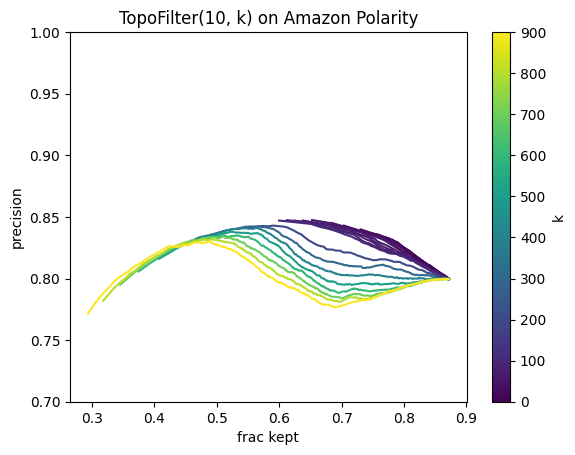

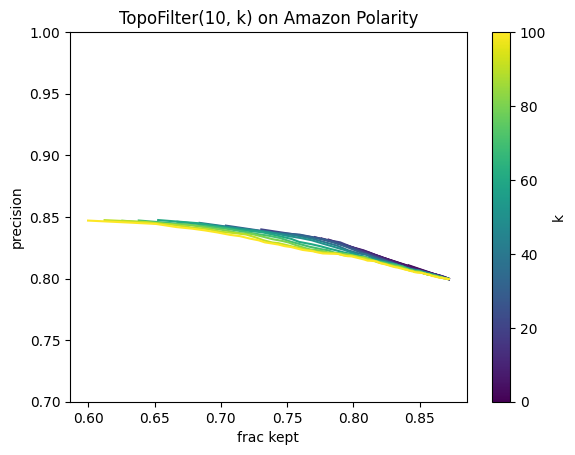

In [72]:
ks_success, ms_success, aucs, counts = result_10_k

plot_frac_prec(ms_success, aucs, counts, "TopoFilter(10, k) on Amazon Polarity")

ms_success = [k for k in ms_success if k <= 100]
plot_frac_prec(ms_success, aucs, counts, "TopoFilter(10, k) on Amazon Polarity")

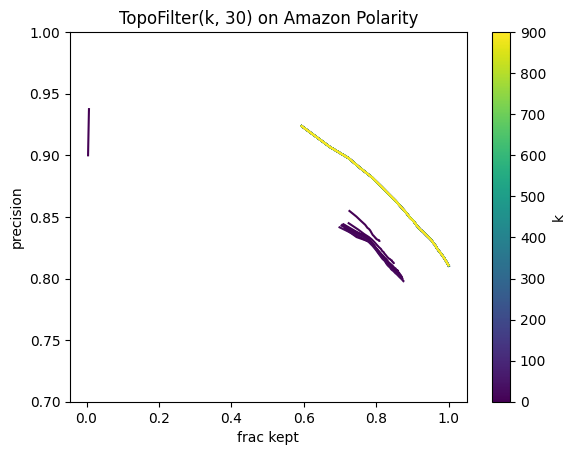

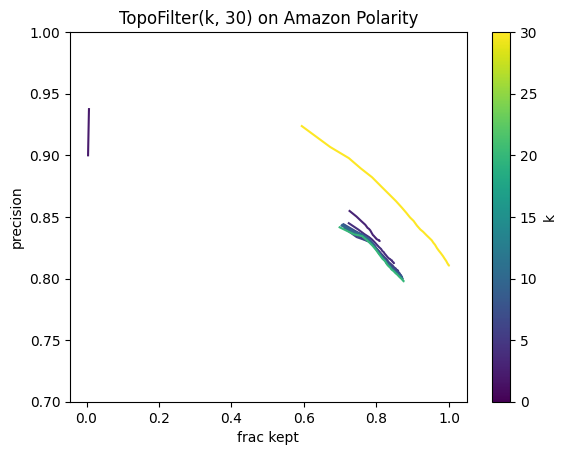

In [86]:
ks_success, ms_success, aucs, counts = result_k_30

plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, 30) on Amazon Polarity")

ks_success = [k for k in ks_success if k <= 30]
plot_frac_prec(ks_success, aucs, counts, "TopoFilter(k, 30) on Amazon Polarity")

# Alex stuff

In [ ]:
from concept_erasure import LeaceEraser
from typing import Literal

def erase_labels(x, soft_labels, label_erasure: Literal["none", "leace", "mean-diff", "keep-negative", "keep-positive"] = "none"):
    mask = np.full_like(soft_labels, True, dtype=bool)
    if label_erasure == "leace":
        eraser = LeaceEraser.fit(x=torch.from_numpy(x), z=torch.from_numpy(soft_labels > 0.5))
        erased = eraser(x=torch.tensor(x)).numpy()
    elif label_erasure == "mean-diff":
        pos_mean = np.mean(x * soft_labels[:, None], axis=0)
        neg_mean = np.mean(x * (1 - soft_labels)[:, None], axis=0)
        mean_diff = pos_mean - neg_mean
        mean_diff = mean_diff / np.linalg.norm(mean_diff)
        erased = x - x @ mean_diff[:, None] * mean_diff[None, :] / (mean_diff @ mean_diff)
    elif label_erasure == "keep-negative":
        mask = soft_labels < 0.5
        erased = x[mask]
    elif label_erasure == "keep-positive":
        mask = soft_labels > 0.5
        erased = x[mask]
    elif label_erasure == "none":
        erased = x
    else:
        raise ValueError(f"Unknown label erasure method {label_erasure}")
    return erased, mask

In [ ]:
# quirky addition
# weak_path = "../results/quirky/sub-mul/dn=quirky_subtraction-ntr=6000-nte=500"
# strong_path = "../results/quirky/sub-mul/bs=32-dl=1-dn=quir_subt-e=3-ee=50-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-subtraction-random-ntd=500-ntd=6000-ntd=0-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/quirky/sub-mul/bs=64-dl=1-dn=quir_subt-e=1-ee=25-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-subtraction-random-ntd=500-ntd=6000-ntd=0-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Bob"

# # quirky addition
# weak_path = "../results/quirky/nli-hem-add/dn=quirky_addition-ntr=8000-nte=500"
# strong_path = "../results/quirky/nli-hem-add/bs=32-dl=1-dn=quir_addi-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-addition-random-ntd=500-ntd=8000-ntd=0-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/quirky/nli-hem-add/bs=64-dl=1-dn=quir_addi-e=1-ee=25-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-addition-random-ntd=500-ntd=8000-ntd=0-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Bob"

# # quirky hemi
# weak_path = "../results/quirky/nli-hem-add/dn=quirky_hemisphere-ntr=8000-nte=500"
# strong_path = "../results/quirky/nli-hem-add/bs=32-dl=1-dn=quir_hemi-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-hemisphere-random-ntd=500-ntd=8000-ntd=0-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/quirky/nli-hem-add/bs=64-dl=1-dn=quir_hemi-e=1-ee=25-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-hemisphere-random-ntd=500-ntd=8000-ntd=0-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Bob"

# # quirky nli
# weak_path = "../results/quirky/nli-hem-add/dn=quirky_nli-ntr=8000-nte=500"
# strong_path = "../results/quirky/nli-hem-add/bs=32-dl=1-dn=quir_nli-e=2-ee=50-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-nli-random-ntd=500-ntd=8000-ntd=0-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/quirky/nli-hem-add/bs=64-dl=1-dn=quir_nli-e=1-ee=25-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-nli-random-ntd=500-ntd=8000-ntd=0-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Bob"

# quirky sciq
# weak_path = "../results/quirky/sciq/dn=quirky_sciq-ntr=3000-nte=300"
# strong_path = "../results/quirky/sciq/bs=32-dl=1-dn=quir_sciq-e=1-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Mistral-7B-v0.1-sciq-random-ntd=300-ntd=3000-ntd=0-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/quirky/sciq/bs=128-dl=1-dn=quir_sciq-e=1-ee=25-gib=1-lp=0-lbmae=1-l=kl-l=2e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Mistral-7B-v0.1-sciq-random-ntd=300-ntd=3000-ntd=0-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Bob"

# # quirky sentiment
# weak_path = "../results/quirky/sentiment/dn=quirky_sentiment-ntr=3000-nte=300"
# strong_path = "../results/quirky/sentiment/bs=32-dl=1-dn=quir_sent-e=1-ee=50-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-sentiment-random-ntd=300-ntd=3000-ntd=0-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/quirky/sentiment/bs=128-dl=1-dn=quir_sent-e=1-ee=25-lp=0-lbmae=1-l=kl-l=2e-05-ls=cosi_anne-mc=512-ms=Mistral-7B-v0.1-sentiment-random-ntd=300-ntd=3000-ntd=0-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Bob"

# amazon_polarity
weak_path = "../results/function-grads/amazon_polarity/bs=32-dl=1-dn=amaz_pola-e=1-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=pythia-14m-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=0-twd=0"
strong_path = "../results/function-grads/amazon_polarity/bs=32-dl=1-dn=amaz_pola-e=1-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Qwen1.5-0.5B-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=0-twd=0"
w2s_path = "../results/function-grads/amazon_polarity/bs=64-dl=1-dn=amaz_pola-e=1-ee=25-gib=1-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Qwen1.5-0.5B-ntd=500-ntd=10000-ntd=10000-o=Adam-stl=1-s=0-sg=1-twd=0-wms=pythia-14m"

# mc taco
# weak_path = "../results/function-grads/mc_taco/bs=32-dl=1-dn=mc_taco-e=3-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=pythia-410m-ntd=300-ntd=4000-ntd=5000-o=Adam-stl=1-s=0-sg=0-twd=0"
# strong_path = "../results/function-grads/mc_taco/bs=32-dl=1-dn=mc_taco-e=3-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Qwen1.5-1.8B-ntd=300-ntd=4000-ntd=5000-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/function-grads/mc_taco/bs=64-dl=1-dn=mc_taco-e=2-ee=25-gib=1-lp=0-lbmae=1-l=kl-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Qwen1.5-1.8B-ntd=300-ntd=4000-ntd=5000-o=Adam-stl=1-s=0-sg=1-twd=0-wms=pythia-410m"

# boolq
# weak_path = "../results/function-grads/boolq/bs=32-dl=1-dn=boolq-e=6-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auroc-ms=Qwen1.5-0.5B-ntd=500-ntd=4000-ntd=5000-o=Adam-stl=1-s=0-sg=0-twd=0"
# strong_path = "../results/function-grads/boolq/bs=32-dl=1-dn=boolq-e=6-ee=50-gib=1-lp=0-lbmae=1-l=xent-l=1e-07-ls=cosi_anne-mc=512-mfbm=auroc-ms=Mistral-7B-v0.1-ntd=500-ntd=4000-ntd=5000-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/function-grads/boolq/bs=64-dl=1-dn=boolq-e=2-ee=25-gib=1-lp=0-lbmae=1-l=kl-l=1e-07-ls=cosi_anne-mc=512-mfbm=auroc-ms=Mistral-7B-v0.1-ntd=500-ntd=4000-ntd=5000-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Qwen1.5-0.5B"

# hhrlhf

# # sciq
# weak_path = "../results/function-grads/sciq-adam/bs=32-dl=1-dn=sciq-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=1e-05-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=Adam-stl=1-s=0-sg=0-twd=0"
# strong_path = "../results/function-grads/sciq-adam/bs=32-dl=1-dn=sciq-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=1e-07-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Mistral-7B-v0.1-ntd=300-ntd=4000-ntd=5500-o=Adam-stl=1-s=0-sg=0-twd=0"
# w2s_path = "../results/function-grads/sciq-adam/bs=64-dl=1-dn=sciq-e=2-ee=10-gib=1-lp=0-lbmae=0-l=kl-l=1e-07-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Mistral-7B-v0.1-ntd=300-ntd=4000-ntd=5500-o=Adam-stl=1-s=0-sg=1-twd=0-wms=Qwen1.5-0.5B"
# SGD
# w2s_path = "../results/function-grads/sciq/bs=64-dl=1-dn=sciq-e=1-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=0.0015-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Mistral-7B-v0.1-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=1-s=0-sg=1-twd=0-wms=Qwen1.5-0.5B"
# strong_path = "../results/function-grads/sciq/bs=32-dl=1-dn=sciq-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Mistral-7B-v0.1-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=1-s=0-sg=0-twd=0"
# weak_path = "../results/function-grads/sciq/bs=32-dl=1-dn=sciq-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=1-s=0-sg=0-twd=0"

# # sciq with support
# w2s_path = "../results/function-grads/bs=64-dl=1-dn=sciq_with_supp-e=10-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=8.999999999999999e-05-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=1-twd=0-wms=opt-350m"
# # w2s_path = "../results/function-grads/bs=64-dl=1-dn=sciq_with_supp-e=2-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=0.00030000000000000003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=1-twd=0-wms=opt-350m"
# # w2s_path = "../results/function-grads/bs=64-dl=1-dn=sciq_with_supp-e=2-ee=25-gib=1-lp=0-lbmae=0-l=kl-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=1-twd=0-wms=opt-350m"
# strong_path = "../results/function-grads/bs=32-dl=1-dn=sciq_with_supp-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=0-twd=0"
# weak_path = "../results/function-grads/bs=32-dl=1-dn=sciq_with_supp-e=5-ee=10000000-gib=1-lp=0-lbmae=0-l=xent-l=0.003-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=opt-350m-ntd=300-ntd=4000-ntd=5500-o=SGD-stl=50-s=0-sg=0-twd=0"

r = load_run_result(w2s_path, weak_path, strong_path)
assert np.all((r.grads.gt_soft_labels == 0) | (r.grads.gt_soft_labels == 1)), "soft gt labels lead to inaccurate assumptions about weak_error's meaning"
print(f"Weak acc: {r.weak_acc:.3f}")
print(f"Strong acc: {r.strong_acc:.3f}")
print(f"W2S acc: {r.w2s_acc:.3f} (PGR: {r.pgr:.3f})")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
import seaborn as sns

weak_label_erased, mask = erase_labels(r.grads.kernel_grads, r.grads.weak_soft_labels, label_erasure="none")

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
svd = TruncatedSVD(n_components=2)
svd1, svd2 = svd.fit_transform(weak_label_erased).T
plt.scatter(svd1, svd2, c=r.grads.weak_error[mask], cmap="coolwarm", alpha=0.5, vmin=-1, vmax=1)
# plt.scatter(svd1, svd2, c=r.grads.steps[mask], cmap="coolwarm", alpha=0.5)
plt.xlabel(f"SVD1 (expl. var. ratio: {svd.explained_variance_ratio_[0]:.3f})")
plt.ylabel(f"SVD2 (expl. var. ratio: {svd.explained_variance_ratio_[1]:.3f})")

print(f"--- SVD ---")
print(f"Explained squared-Frobenious norm ratio: {svd.explained_variance_ratio_}")
print(f"AUROC of y axis {roc_auc_score(np.abs(r.grads.weak_error[mask]) < 0.5, svd2):.3f}")
plt.colorbar(label="weak error")


basis1 = np.ones(r.w2s_test.n) / np.sqrt(r.w2s_test.n)

for i, yaxis_name in enumerate(["weak_test_logodds", "test_gt_soft_labels", "strong_test_logodds"]):
    
    if yaxis_name == "weak_test_logodds":
        yaxis = r.weak_test.logodds
    elif yaxis_name == "test_gt_soft_labels":
        p = r.w2s_test.gt_soft_labels
        yaxis = np.log(p / ((1 - p) + 1e-8) + 1e-8)
    elif yaxis_name == "strong_test_logodds":
        yaxis = r.strong_test.logodds

    basis2 = yaxis / np.linalg.norm(yaxis)
    increase_probs = weak_label_erased @ basis1
    report_knowledge = weak_label_erased @ basis2

    plt.subplot(2, 2, 2 + i)
    plt.scatter(increase_probs, report_knowledge, c=r.grads.weak_error[mask], cmap="coolwarm", alpha=0.5, vmin=-1, vmax=1)
    # plt.scatter(increase_probs, report_knowledge, c=r.grads.steps[mask], cmap="coolwarm", alpha=0.5)

    frob_norm = np.sum(weak_label_erased**2)
    ev1 = np.sum((weak_label_erased @ basis1)**2) / frob_norm
    ev2 = np.sum((weak_label_erased @ basis2)**2) / frob_norm
    
    plt.xlabel(f"\"increase output probs\"$\\to$\n(expl. var. ratio: {ev1:.3f})")
    plt.ylabel(f"\"report your knowledge\"$\\to$\n(proj onto {yaxis_name})\n(expl. var. ratio: {ev2:.3f})")

    print(f"--- {yaxis_name} ---")
    print(f"Explained squared-Frobenious norm ratio: {ev1:.3f} (basis1), {ev2:.3f} (basis2)")
    print(f"AUROC of y axis {roc_auc_score(np.abs(r.grads.weak_error[mask]) < 0.5, report_knowledge):.3f}")
    
plt.savefig(os.path.join(w2s_path, f"2D-kernel-grads.pdf"), bbox_inches="tight")
plt.tight_layout()
plt.show()


In [ ]:
from torch.nn.functional import sigmoid, logsigmoid, kl_div

def kl_of_update(start_logodds, delta_logodds):
    """Elementwise kl divergence induced by delta_logodds update from start_logodds.
    Tested against torch.nn.functional.kl_div."""
    o0, delta = torch.tensor(start_logodds).half(), torch.tensor(delta_logodds).double()
    # p0 * (log(p0) - log(p1)) + (1 - p0) * (log(1 - p0) - log(1 - p1))
    return (sigmoid(o0) * (logsigmoid(o0) - logsigmoid(o0 + delta)) + 
        sigmoid(-o0) * (logsigmoid(-o0) - logsigmoid(-o0 - delta))).numpy()

In [ ]:
label_erasure = "mean-diff"
weak_label_erased, mask = erase_labels(r.grads.kernel_grads, r.grads.weak_soft_labels, label_erasure=label_erasure)

### size of [average effect] ###
cthresh = 0.3
cm = np.abs(r.grads.weak_error) < cthresh
im = np.abs(r.grads.weak_error) > 1 - cthresh
correct_avg_effect = weak_label_erased[cm].mean(axis=0)
incorrect_avg_effect = weak_label_erased[im].mean(axis=0)
print(f"correct if weak_error < {cthresh}: {cm.sum()} examples")
print(f"incorrect if weak_error > {1 - cthresh}: {im.sum()} examples")

print(f"L2 norm of [average correct effect]: {np.linalg.norm(correct_avg_effect):.3f}")
print(f"L2 norm of [average incorrect effect]: {np.linalg.norm(incorrect_avg_effect):.3f}")

assert r.grads.steps[0] == 0, "test_logodds[0] is not the initial logodds"
kl_correct = kl_of_update(r.grads.test_logodds[0], correct_avg_effect)
kl_incorrect = kl_of_update(r.grads.test_logodds[0], incorrect_avg_effect)
correct_mean = kl_correct.mean()
incorrect_mean = kl_incorrect.mean()
correct_stderr = np.std(kl_correct) / np.sqrt(len(kl_correct))
incorrect_stderr = np.std(kl_incorrect) / np.sqrt(len(kl_incorrect))
print_scale = 10 ** np.ceil(-np.log10(np.abs(correct_mean)))
print(f"KL norm of [average correct effect]: ({print_scale * correct_mean:.3f} +/- {print_scale * 2 * correct_stderr:.3f}) * 10^{-np.log10(print_scale)}")
print(f"KL norm of [average incorrect effect]: ({print_scale * incorrect_mean:.3f} +/- {print_scale * 2 * incorrect_stderr:.3f}) * 10^{-np.log10(print_scale)}")

### average size of effect ###
if label_erasure == "none":
    print("WARNING: norm measurements are not meaningful when label erasure is not applied")

# first using L2
correct_norms = np.linalg.norm(weak_label_erased[cm], axis=1)
incorrect_norms = np.linalg.norm(weak_label_erased[im], axis=1)
correct_avg_norm = np.mean(correct_norms)
incorrect_avg_norm = np.mean(incorrect_norms)
correct_sem_norm = np.std(correct_norms) / np.sqrt(len(correct_norms))
incorrect_sem_norm = np.std(incorrect_norms) / np.sqrt(len(incorrect_norms))
print_scale = 10 ** np.ceil(-np.log10(np.abs(correct_avg_norm)))
print("(mean +/- 2*stderr)")
print(f"Average [L2 norm of correct effect]: ({print_scale * correct_avg_norm:.2f} +/- {print_scale * 2 * correct_sem_norm:.2f}) * 10^{-np.log10(print_scale)}")
print(f"Average [L2 norm of incorrect effect]: ({print_scale * incorrect_avg_norm:.2f} +/- {print_scale * 2 * incorrect_sem_norm:.2f}) * 10^{-np.log10(print_scale)}")

# now using KL
kl = kl_of_update(r.grads.test_logodds, weak_label_erased).mean(axis=1)

correct_kls = kl[cm]
incorrect_kls = kl[im]
correct_avg_kl = correct_kls.mean()
incorrect_avg_kl = incorrect_kls.mean()
correct_sem_kl = correct_kls.std() / np.sqrt(len(correct_kls))
incorrect_sem_kl = incorrect_kls.std() / np.sqrt(len(incorrect_kls))
print_scale = 10 ** np.ceil(-np.log10(np.abs(correct_avg_kl)))
print(f"Average [KL norm of correct effects]: ({print_scale * correct_avg_kl:.2f} +/- {print_scale * 2 * correct_sem_kl:.2f}) * 10^{-np.log10(print_scale)}")
print(f"Average [KL norm of incorrect effects]: ({print_scale * incorrect_avg_kl:.2f} +/- {print_scale * 2 * incorrect_sem_kl:.2f}) * 10^{-np.log10(print_scale)}")

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

print(f"Weak floor val accuracy {r.weak_acc:.4f}")
print(f"Strong ceiling val accuracy {r.strong_acc:.4f}")
print(f"Original W2S val accuracy {r.w2s_acc:.4f} (PGR: {r.pgr:.4f})\n")

filtering_results = []
for probe_type in ["weak_test_proj", "gt_test_proj", "mean-diff", "lr"]:
    for label_erasure in ["none", "mean-diff", "leace"]:

        weak_label_erased, mask = erase_labels(r.grads.kernel_grads, r.grads.weak_soft_labels, label_erasure=label_erasure)
        is_correct = np.abs(r.grads.weak_error[mask]) < 0.5


        if probe_type == "svd2":
            probe = svd.components_[1]
        elif probe_type == "gt_test_proj":
            probe = r.w2s_test.gt_hard_labels - np.mean(r.w2s_test.gt_hard_labels)
            probe = probe / np.linalg.norm(probe)
        elif probe_type == "weak_test_proj":
            probe = r.weak_test.logodds - np.mean(r.weak_test.logodds)
            probe = probe / np.linalg.norm(probe)
        elif probe_type == "strong_test_proj":
            probe = r.strong_test.logodds - np.mean(r.strong_test.logodds)
            probe = probe / np.linalg.norm(probe)
        elif probe_type == "lr" or probe_type == "mean-diff":
            weak_label_erased = weak_label_erased / np.linalg.norm(weak_label_erased, axis=1)[:, None]
            n_train = min(1000, len(weak_label_erased) // 8)
            print(f"Using {n_train} of {len(weak_label_erased)} examples for probe fitting")
            weak_label_erased_train, weak_label_erased = weak_label_erased[:n_train], weak_label_erased[n_train:]
            y_train, is_correct = is_correct[:n_train], is_correct[n_train:]
            if probe_type == "lr":
                probe = LogisticRegression(C=1).fit(weak_label_erased_train, y_train).coef_[0]
            else:
                probe = weak_label_erased_train[y_train].mean(axis=0) - weak_label_erased_train[~y_train].mean(axis=0)
        else:
            raise ValueError(f"Unknown probe type {probe_type}")

        projs = weak_label_erased @ probe
        percentile = 50
        proj_thresh = np.percentile(projs, percentile)
        filter = projs > proj_thresh
        new_weak_label_acc = np.mean(is_correct[filter])
        new_pgr = (new_weak_label_acc - r.weak_acc) / (r.strong_acc - r.weak_acc)
        try:
            auc = roc_auc_score(is_correct, projs)
        except ValueError:
            auc = np.nan
        # print(f"Probe type: {probe_type}; Label erasure method: {label_erasure}")
        # print(f"Weak label accuracy conditional on probe score in >={percentile}th percentile: {new_weak_label_acc:.4f} (PGR*: {new_pgr:.4f})")
        # print(f"Probe AUROC at classifying labeling errors: {auc:.4f}")
        filtering_results.append({
            "probe_type": probe_type,
            "label_erasure": label_erasure,
            "new_weak_label_acc": new_weak_label_acc,
            "quasi_pgr": new_pgr,
            "auroc": auc,
            "percentile": percentile,
        })
fdf = pd.DataFrame(filtering_results)

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 1)
sns.barplot(data=fdf, x="probe_type", y="auroc", hue="label_erasure")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.gca().get_legend().remove()


plt.subplot(3, 1, 2)
sns.barplot(data=fdf, x="probe_type", y="new_weak_label_acc", hue="label_erasure")
old_weak_label_acc = ((r.w2s_train.weak_soft_labels > 0.5) == r.w2s_train.gt_soft_labels).mean()
plt.axhline(old_weak_label_acc, color="black", linestyle="--", label="Original weak label accuracy")
plt.xticks(rotation=45)
plt.legend(loc=[1.01, 0.], title="Label erasure")

plt.subplot(3, 1, 3)
sns.barplot(data=fdf, x="probe_type", y="quasi_pgr", hue="label_erasure")
plt.xticks(rotation=45)
plt.gca().get_legend().remove()

plt.suptitle(f"weak label filtering at {percentile}%")
plt.tight_layout()
plt.savefig(os.path.join(w2s_path, "filtering_results.pdf"), bbox_inches="tight")
plt.show()